In [1]:
import pandas as pd
import numpy as np
import joblib as jb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_ratio
import xgboost as XGB
from lightgbm import LGBMRegressor
import lightgbm as lgb
from bayes_opt import BayesianOptimization

In [3]:
train_path = 'generated/train_window_split_RAW.pkl.z'
val_path = 'generated/val_window_split_RAW.pkl.z'

train = jb.load(train_path)
val = jb.load(val_path)
#df['ndwi51'] =  df[['b5', 'b1']].apply(lambda x: pixel_ndwi(x.b5, x.b1), axis=1)
val.head()

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,b2b4,b3b4,ndwi15,ndwi24,ndwi53,cspmb7,ndwi51
8,234,1003,2.230000,0.1224,0.0917,0.0725,0.0509,0.0554,0.0345,0.0331,0.0264,1.149791,1.090009,0.376828,0.286115,-0.133698,28.922021,-0.376828
9,234,1004,2.229857,0.1224,0.0917,0.0734,0.0514,0.0540,0.0336,0.0323,0.0264,1.146938,1.090436,0.387755,0.281621,-0.152276,27.977559,-0.387755
10,234,1005,2.229851,0.1224,0.0919,0.0732,0.0509,0.0540,0.0336,0.0323,0.0265,1.150346,1.092454,0.387755,0.287115,-0.150943,27.977559,-0.387755
11,234,1006,2.230000,0.1224,0.0925,0.0722,0.0505,0.0536,0.0329,0.0328,0.0257,1.154319,1.091145,0.390909,0.293706,-0.147854,28.566881,-0.390909
12,234,1007,2.230000,0.1224,0.0920,0.0717,0.0517,0.0536,0.0329,0.0328,0.0254,1.146075,1.082888,0.390909,0.280445,-0.144453,28.566881,-0.390909


In [4]:
train_no_outliers = train.copy()
val_no_outliers = val.copy()

NameError: name 'test' is not defined

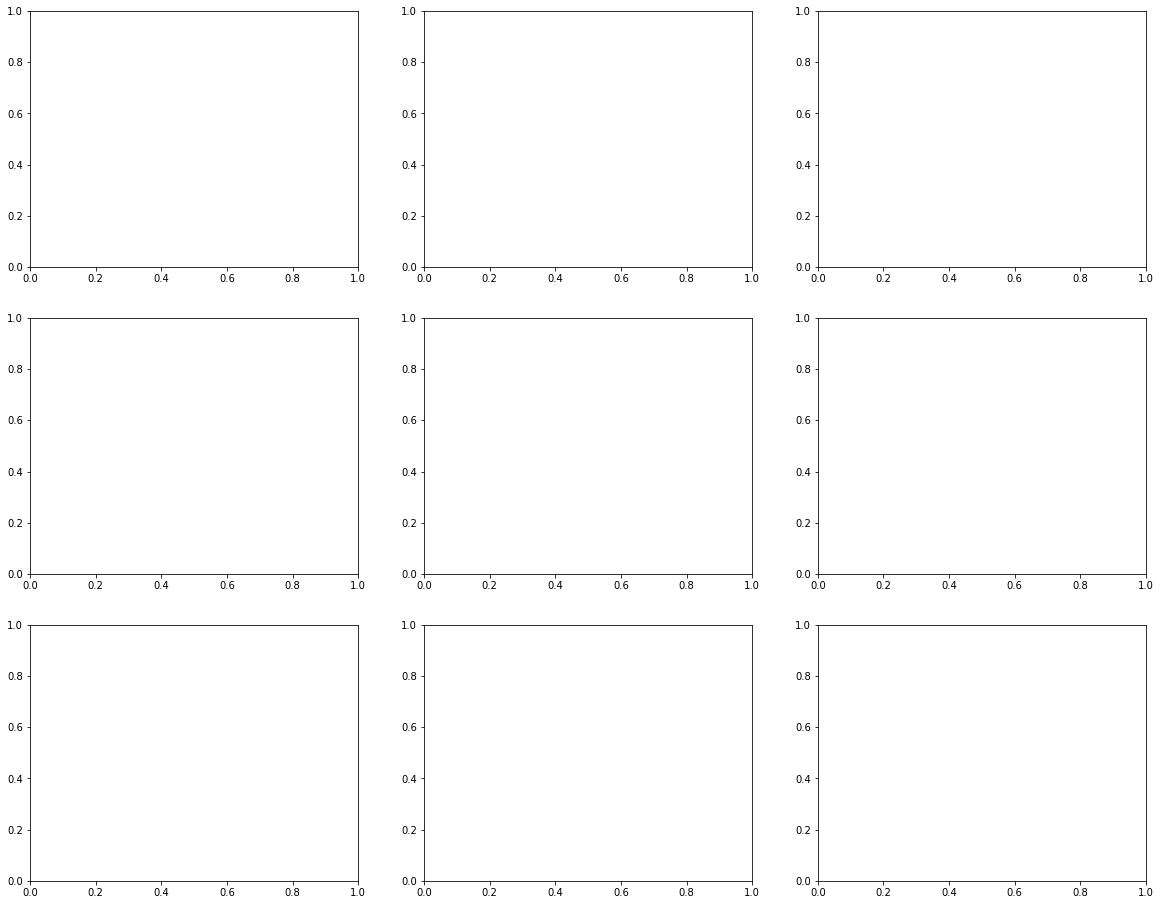

In [9]:
# Some bands  and cspm boxplot
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 16))
sns.boxplot(y=test.b1, ax=ax[0,0])
sns.boxplot(y=test.b2, ax=ax[0,1])
sns.boxplot(y=test.b3, ax=ax[0,2])
sns.boxplot(y=test.b4, ax=ax[1,0])
sns.boxplot(y=test.b5, ax=ax[1,1])
sns.boxplot(y=test.b6, ax=ax[1,2])
sns.boxplot(y=test.b7, ax=ax[2,0])
sns.boxplot(y=test.b8, ax=ax[2,1])
sns.boxplot(y=test.cspmb7, ax=ax[2,2])

In [5]:
# Remove outliers on b7, b8, b6
print('N outliers b7:', len(train_no_outliers[train_no_outliers.b7 > 0.032]))
print('N outliers b8:', len(train_no_outliers[train_no_outliers.b8 > 0.029]))
print('N outliers b6:', len(train_no_outliers[train_no_outliers.b6 > 0.035]))

N outliers b7: 742
N outliers b8: 384
N outliers b6: 566


In [6]:
print(len(train_no_outliers), len(train_no_outliers[train_no_outliers.b7 > 0.032]))
print(len(train_no_outliers) - 742)

12079 742
11337


In [7]:
index_to_drop_train = set(list(train_no_outliers[train_no_outliers.b7 > 0.032].index) + list(train_no_outliers[train_no_outliers.b8 > 0.029].index) + list(train_no_outliers[train_no_outliers.b6 > 0.035].index))

In [8]:
train_droped_outliers = train_no_outliers.drop(index_to_drop_train)
train_droped_outliers.head()

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,b2b4,b3b4,ndwi15,ndwi24,ndwi53,cspmb7,ndwi51
0,233,1130,3.195862,0.1199,0.0866,0.0667,0.0464,0.0490,0.0316,0.0283,0.0238,1.162614,1.094573,0.419775,0.302256,-0.152982,23.382784,-0.419775
1,233,1131,3.273030,0.1199,0.0880,0.0668,0.0457,0.0490,0.0316,0.0283,0.0237,1.171434,1.099318,0.419775,0.316380,-0.153713,23.382784,-0.419775
2,233,1132,3.299687,0.1199,0.0879,0.0666,0.0461,0.0488,0.0324,0.0281,0.0238,1.168473,1.096035,0.421458,0.311940,-0.154246,23.158824,-0.421458
3,233,1133,3.268182,0.1199,0.0882,0.0692,0.0452,0.0488,0.0324,0.0281,0.0232,1.175411,1.111754,0.421458,0.322339,-0.172881,23.158824,-0.421458
4,233,1134,3.278125,0.1196,0.0884,0.0677,0.0454,0.0489,0.0323,0.0285,0.0238,1.174645,1.104724,0.419585,0.321375,-0.161235,23.607309,-0.419585
